In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
# warnings.filterwarnings('ignore')

## Read the data from the Excel file and print some information about it

In [2]:
dataAll = pd.read_excel('../data/GTA/globalterrorismdb_0616dist.xlsx')

In [3]:
dataAll.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156772 entries, 0 to 156771
Columns: 137 entries, eventid to related
dtypes: datetime64[ns](1), float64(55), int64(24), object(57)
memory usage: 163.9+ MB


## Select the features we want to train our model with
There are many features to select from. However 10 features that thier information are available for most of the attacks are chosen as below 
- **iyear**: Year of the attack
- **country**: Country where the incident occurred
- **suicide**: Whether the incident was a suicide attack
- **attacktype1**: Consists of nine attck type categories (Assassination, Hijacking, Kidnapping, Barricade Incident, Bombing/Explosion, Armed Assault, Unarmed Assault, Facility/Infrastructure Attack, Unknown)
- **targtype1**: Captures the general type of target/victim comprising of 22 categories
- **weaptype1**: The general type of weapon used in the incident consisting of 13 weapon types
- **ransom**: Whether the incident involved a demand of monetary ransom
- **crit1**: Whether the goal of attackers was political, economic, religious, or social
- **crit2**: Whether the goal of attackers was to coerce, intimidate, or convey some other message to a larger audience than the immediate victims
- **crti3**: Whether the action is outside the context of legitimate warfare activities, insofar as it targets non‐combatants

In [62]:
features = ['iyear', 'country', 'suicide', 'attacktype1', 'targtype1', 'weaptype1', 'ransom', 'crit1', 'crit2', 'crit3']

In [63]:
feature_and_outputs = features + ['gname', 'ingroup']
data = dataAll[feature_and_outputs]
data.head()

,iyear,country,suicide,attacktype1,targtype1,weaptype1,ransom,crit1,crit2,crit3,gname,ingroup
0,1970,58,0,1,14,13,0.0,1,1,1,MANO-D,3629
1,1970,130,0,6,7,13,1.0,1,1,1,23rd of September Communist League,3330
2,1970,160,0,1,10,13,0.0,1,1,1,Unknown,-9
3,1970,78,0,3,7,6,0.0,1,1,1,Unknown,-9
4,1970,101,0,7,7,8,0.0,1,1,1,Unknown,-9


## Removing attacks with unknown feature data

In [64]:
nDataBefore = data.shape[0]
data = data[(dataAll['attacktype1_txt'] != 'Unknown') & 
            (dataAll['targtype1_txt'] != 'Unknown') &
            (dataAll['weaptype1_txt'] != 'Unknown')]
print('After removing rows with unknown features the number of rows went down from {} to {}'.format(nDataBefore, data.shape[0]))

After removing rows with unknown features the number of rows went down from 156772 to 140717


## Remove attacks commited by attackers that we don't have too many information about them

In [65]:
minAttacks = 400
nTotalAttackers = data['gname'].nunique()
nTotalAttacks   = data.shape[0]

# Add 'gNumAttack' column which shows the number of attacks commited by the attacker of each attack
nAttackByGroup = data['gname'].value_counts().to_frame('nattack')
nAttackByGroup['gID'] = np.arange(nAttackByGroup.shape[0])
data[['gNumAttack','gID']] = data['gname'].apply(lambda x: nAttackByGroup.loc[x][:])

# Remove the attacks with little attacker info
data = data[data['gNumAttack'] > minAttacks]

# Print useful info
nNewAttackers = data['gname'].nunique()
nNewAttacks   = data.shape[0]
print('Before removing attacks with few attacker information we had {} attacks with {} unique attackers.'.format(nTotalAttacks, nTotalAttackers))
print('After removing attacks with few attacker information we have {} attacks with {} unique attackers.'.format(nNewAttacks, nNewAttackers))

Before removing attacks with few attacker information we had 140717 attacks with 2970 unique attackers.
After removing attacks with few attacker information we have 108790 attacks with 32 unique attackers.


## Exploratory Data Analysis
** Determine which of the chosen features is not suitable for our training because of too many missing data**

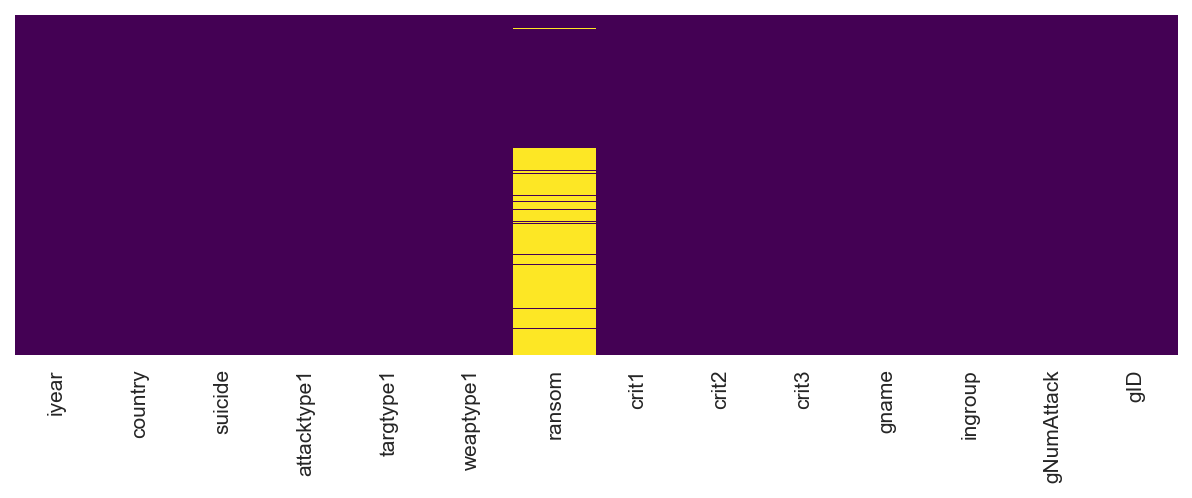

In [66]:
plt.figure(figsize=(10,3),dpi=150)
sns.heatmap(data.isnull(),yticklabels=False,cbar=False,cmap='viridis')

**So we will remove 'ransom' from our features**

In [67]:
data = data.drop('ransom', 1)
features.remove('ransom')
data.head()

,iyear,country,suicide,attacktype1,targtype1,weaptype1,crit1,crit2,crit3,gname,ingroup,gNumAttack,gID
3,1970,78,0,3,7,6,1,1,1,Unknown,-9,65701,0
4,1970,101,0,7,7,8,1,1,1,Unknown,-9,65701,0
7,1970,217,0,3,21,6,1,1,1,Unknown,-9,65701,0
12,1970,98,0,4,6,5,1,1,1,Unknown,-9,65701,0
26,1970,160,0,3,7,6,1,1,1,Unknown,-9,65701,0


### Plot the selected features with respect to the terror groups
This is to make sure that our classification model can be well trained with the selected features

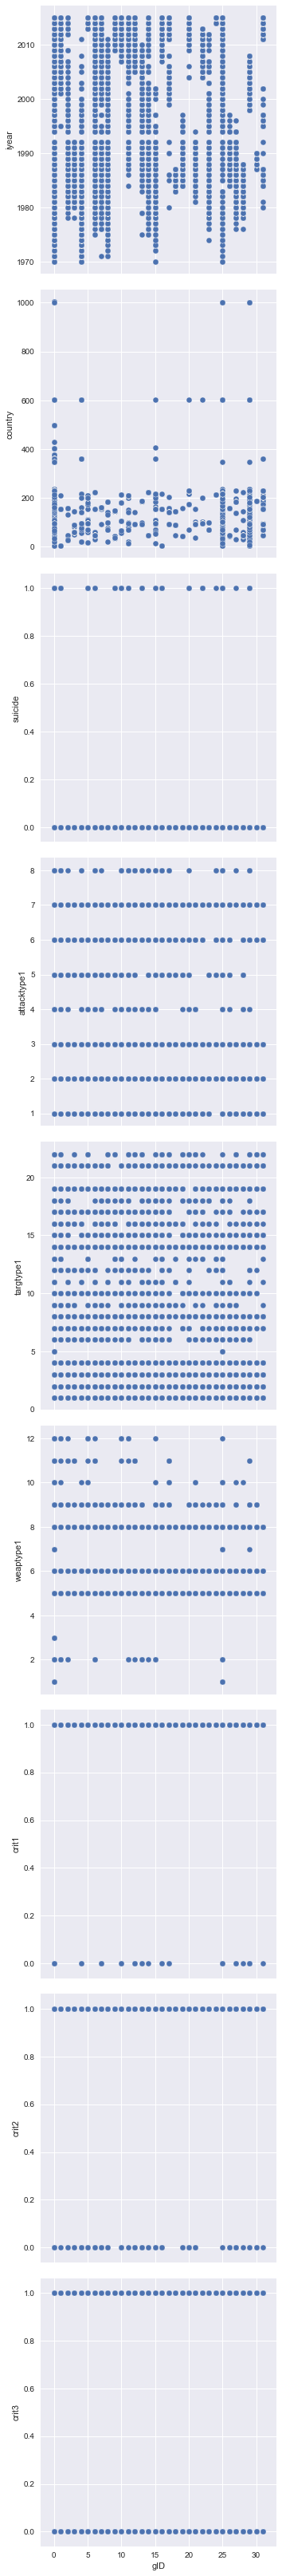

In [68]:
plt.figure(dpi=150)
sns.pairplot(data=data, y_vars=features, x_vars='gID',size=5)

## Feature Scaling

In [69]:
from sklearn import preprocessing

In [70]:
data.describe()

,iyear,country,suicide,attacktype1,targtype1,weaptype1,crit1,crit2,crit3,ingroup,gNumAttack,gID
count,108790.000000,108790.000000,108790.000000,108790.000000,108790.000000,108790.000000,108790.000000,108790.000000,108790.000000,108790.000000,108790.000000,108790.000000
mean,2001.664795,131.472029,0.035187,2.850915,7.975963,5.815856,0.986102,0.995478,0.875788,2856.333808,40557.416196,3.930738
std,12.502149,110.165400,0.184253,1.393447,6.495813,0.890838,0.117070,0.067097,0.329825,8472.677192,31059.721175,7.011864
min,1970.000000,4.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,-9.000000,405.000000,0.000000
25%,1990.000000,78.000000,0.000000,2.000000,3.000000,5.000000,1.000000,1.000000,1.000000,-9.000000,2270.000000,0.000000
50%,2008.000000,98.000000,0.000000,3.000000,4.000000,6.000000,1.000000,1.000000,1.000000,-9.000000,65701.000000,0.000000
75%,2013.000000,160.000000,0.000000,3.000000,14.000000,6.000000,1.000000,1.000000,1.000000,520.000000,65701.000000,5.000000
max,2015.000000,1004.000000,1.000000,8.000000,22.000000,12.000000,1.000000,1.000000,1.000000,40269.000000,65701.000000,31.000000


In [71]:
data[features] = preprocessing.scale(data[features])

In [72]:
data.describe()

,iyear,country,suicide,attacktype1,targtype1,weaptype1,crit1,crit2,crit3,ingroup,gNumAttack,gID
count,1.087900e+05,1.087900e+05,1.087900e+05,1.087900e+05,1.087900e+05,1.087900e+05,1.087900e+05,1.087900e+05,1.087900e+05,108790.000000,108790.000000,108790.000000
mean,-1.022429e-13,2.538670e-14,1.276218e-13,-5.381306e-14,8.035019e-15,-1.548117e-14,1.040946e-14,-7.444762e-15,-1.804087e-14,2856.333808,40557.416196,3.930738
std,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,8472.677192,31059.721175,7.011864
min,-2.532760e+00,-1.157102e+00,-1.909721e-01,-1.328305e+00,-1.073922e+00,-5.406011e+00,-8.423245e+00,-1.483637e+01,-2.655328e+00,-9.000000,405.000000,0.000000
25%,-9.330274e-01,-4.853818e-01,-1.909721e-01,-6.106573e-01,-7.660297e-01,-9.158347e-01,1.187191e-01,6.740193e-02,3.766013e-01,-9.000000,2270.000000,0.000000
50%,5.067316e-01,-3.038357e-01,-1.909721e-01,1.069909e-01,-6.120836e-01,2.067095e-01,1.187191e-01,6.740193e-02,3.766013e-01,-9.000000,65701.000000,0.000000
75%,9.066647e-01,2.589570e-01,-1.909721e-01,1.069909e-01,9.273765e-01,2.067095e-01,1.187191e-01,6.740193e-02,3.766013e-01,520.000000,65701.000000,5.000000
max,1.066638e+00,7.920200e+00,5.236367e+00,3.695232e+00,2.158945e+00,6.941974e+00,1.187191e-01,6.740193e-02,3.766013e-01,40269.000000,65701.000000,31.000000


## Split our data set into two
### One data set with unkonwn attackers information. And another with no unknown attackers

In [73]:
dataUnknownGroup = data[data['gname'] == 'Unknown']
dataKnownGroup   = data[data['gname'] != 'Unknown']

print('Before splitting, the data has %d rows'% data.shape[0])
print('Unkown attaker group has %d rows (%5.2f%% of total rows)'% (dataUnknownGroup.shape[0], dataUnknownGroup.shape[0]/data.shape[0]*100))
print('After removing unkown attackers we have %d rows (%5.2f%% of total rows)\n'% (dataKnownGroup.shape[0], dataKnownGroup.shape[0]/data.shape[0]*100))

Before splitting, the data has 108790 rows
Unkown attaker group has 65701 rows (60.39% of total rows)
After removing unkown attackers we have 43089 rows (39.61% of total rows)



## Logistic Regression model
### Split the data set to Train and CV (cross validation)

In [74]:
from sklearn.model_selection import train_test_split

In [75]:
X_train, X_cv, y_train, y_cv = train_test_split(dataKnownGroup[features], 
                                                dataKnownGroup['gname'], test_size=0.30, 
                                                random_state=101)

### Training and Predicting

In [76]:
from sklearn.linear_model import LogisticRegression

In [77]:
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [78]:
predictions = logmodel.predict(X_cv)

### Evaluation
We can check precision,recall,f1-score using classification report!

In [79]:
from sklearn.metrics import classification_report,confusion_matrix

In [80]:
print(classification_report(y_cv,predictions))

                                                  precision    recall  f1-score   support

        African National Congress (South Africa)       0.11      0.01      0.01       146
                                Al-Qaida in Iraq       1.00      0.02      0.04       191
        Al-Qaida in the Arabian Peninsula (AQAP)       0.65      0.06      0.11       240
                                      Al-Shabaab       0.25      0.54      0.34       494
             Basque Fatherland and Freedom (ETA)       0.14      0.02      0.03       574
                                      Boko Haram       0.19      0.30      0.24       472
  Communist Party of India - Maoist (CPI-Maoist)       0.37      0.58      0.45       407
       Corsican National Liberation Front (FLNC)       0.04      0.01      0.01       166
                       Donetsk People's Republic       0.42      0.22      0.29       140
Farabundo Marti National Liberation Front (FMLN)       0.53      0.84      0.65       981
         

/Users/aminMac/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


**So clearly linear logistic regression is not a good way to represent the data**

**Now we try Random Forest**

## Random Forests

In [81]:
from sklearn.ensemble import RandomForestClassifier

### Fit the model for a range of number of trees

In [82]:
estimatorList = range(2, 101, 4)
pred_f1 = []

for (i, n_est) in enumerate(estimatorList):
    # Train the model
    rfc = RandomForestClassifier(n_estimators=n_est)
    rfc.fit(X_train, y_train)
    
    # make predictions
    rfc_pred = rfc.predict(X_cv)
    pred_report=classification_report(y_cv, rfc_pred, digits=6).split()
    pred_f1.append(float(pred_report[-2]))
    
    # Progress Report
    print('Progress: %2i/%2i ,  n_estimators = %3i ,  Average f1 = %6.4f'%(i+1, len(estimatorList), n_est, pred_f1[-1]))

Progress:  1/25 ,  n_estimators =   2 ,  Average f1 = 0.8997
Progress:  2/25 ,  n_estimators =   6 ,  Average f1 = 0.9150
Progress:  3/25 ,  n_estimators =  10 ,  Average f1 = 0.9224
Progress:  4/25 ,  n_estimators =  14 ,  Average f1 = 0.9236
Progress:  5/25 ,  n_estimators =  18 ,  Average f1 = 0.9240
Progress:  6/25 ,  n_estimators =  22 ,  Average f1 = 0.9237
Progress:  7/25 ,  n_estimators =  26 ,  Average f1 = 0.9192
Progress:  8/25 ,  n_estimators =  30 ,  Average f1 = 0.9247
Progress:  9/25 ,  n_estimators =  34 ,  Average f1 = 0.9253
Progress: 10/25 ,  n_estimators =  38 ,  Average f1 = 0.9216
Progress: 11/25 ,  n_estimators =  42 ,  Average f1 = 0.9235
Progress: 12/25 ,  n_estimators =  46 ,  Average f1 = 0.9256
Progress: 13/25 ,  n_estimators =  50 ,  Average f1 = 0.9247
Progress: 14/25 ,  n_estimators =  54 ,  Average f1 = 0.9247
Progress: 15/25 ,  n_estimators =  58 ,  Average f1 = 0.9245
Progress: 16/25 ,  n_estimators =  62 ,  Average f1 = 0.9253
Progress: 17/25 ,  n_est

### Print f1 score with respect to the number of trees and determine the optimum value

In [83]:
n_est_best_arg = np.argmax(pred_f1)
n_est_best = estimatorList[n_est_best_arg]
print('We get the best f1 score whith {} trees.'.format(n_est_best))

We get the best f1 score whith 78 trees.


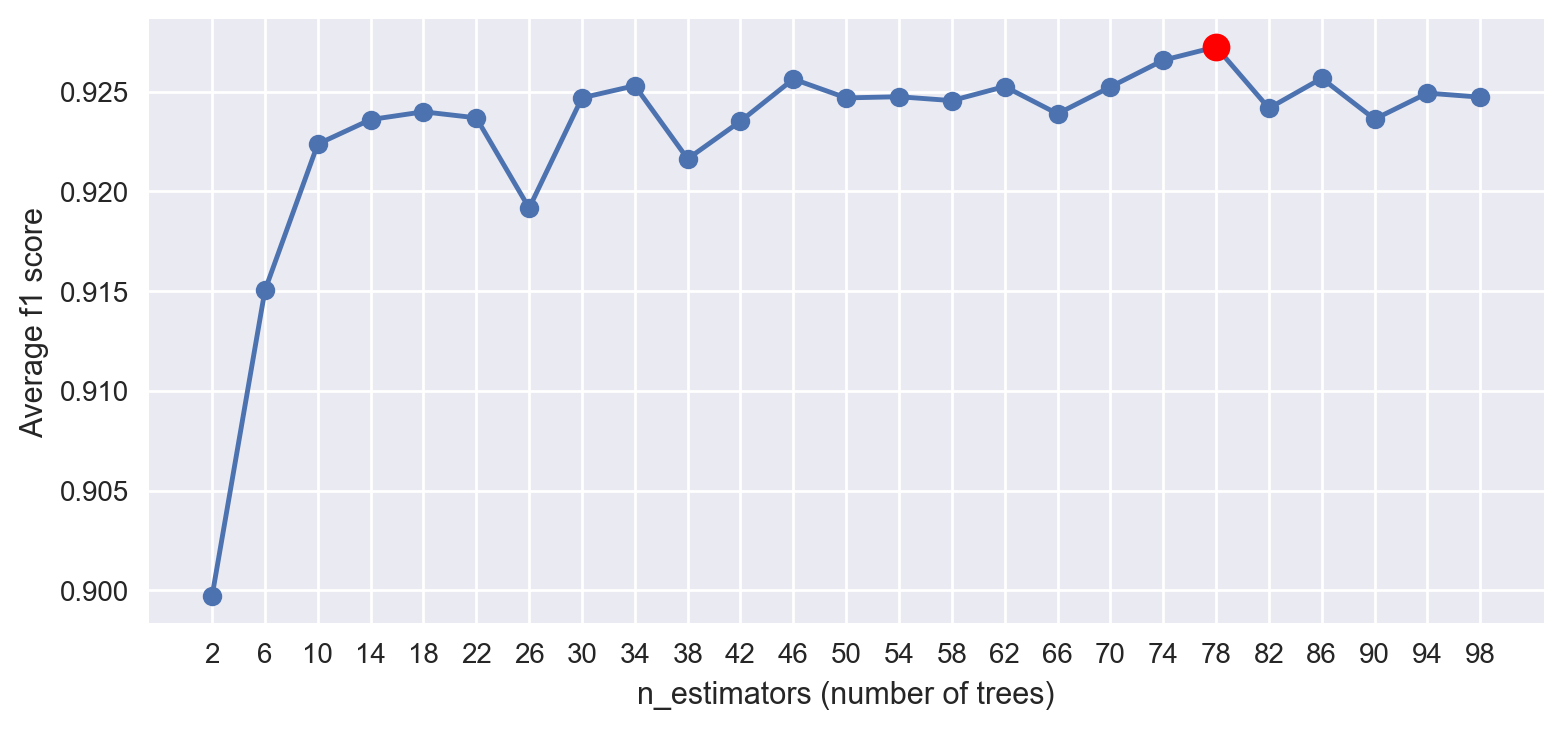

In [84]:
plt.figure(figsize=(9,4),dpi=200)
plt.plot(estimatorList, pred_f1, '-o')
plt.plot(n_est_best, pred_f1[n_est_best_arg],'or',markersize=10)
plt.xticks(estimatorList)
plt.xlabel('n_estimators (number of trees)')
plt.ylabel('Average f1 score')

### Train the model again with the optimum number of trees and print the full classification report

In [85]:
# Train the model
rfc = RandomForestClassifier(n_estimators=n_est_best)
rfc.fit(X_train, y_train)

# make predictions
rfc_pred = rfc.predict(X_cv)

In [86]:
print(classification_report(y_cv,rfc_pred, digits=3))

                                                  precision    recall  f1-score   support

        African National Congress (South Africa)      1.000     0.966     0.983       146
                                Al-Qaida in Iraq      0.942     0.848     0.893       191
        Al-Qaida in the Arabian Peninsula (AQAP)      0.987     0.975     0.981       240
                                      Al-Shabaab      0.972     0.988     0.980       494
             Basque Fatherland and Freedom (ETA)      0.979     0.984     0.982       574
                                      Boko Haram      0.987     1.000     0.994       472
  Communist Party of India - Maoist (CPI-Maoist)      0.911     0.855     0.882       407
       Corsican National Liberation Front (FLNC)      0.884     0.964     0.922       166
                       Donetsk People's Republic      1.000     1.000     1.000       140
Farabundo Marti National Liberation Front (FMLN)      0.998     0.999     0.998       981
         